# Kenya Hack - Tanzania Tourism Prediction Challenge by Nairobi Women In Machine Learning Data Science

## Problem statement

The objective of this hackathon was to develop a machine learning model to predict what a tourist will spend when visiting Tanzania.The model can be used by different tour operators and the Tanzania Tourism Board to automatically help tourists across the world estimate their expenditure before visiting Tanzania. 


The full problem statement can be found on the [competition](https://zindi.africa/hackathons/kenya-hack-tanzania-tourism-prediction-challenge) page.

In [1]:
import pandas as pd
import numpy as np
import requests
from io import StringIO 
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR, NuSVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, StackingRegressor,HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error
import lightgbm
from lightgbm import LGBMRegressor
import catboost
from catboost import CatBoostRegressor
from sklearn.cluster import KMeans
import warnings
from rgf.sklearn import RGFRegressor
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)

In [2]:
# Loading data
train=pd.read_csv('Train.csv')
test_1=pd.read_csv('Test.csv')

In [3]:
train.head()

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing,total_cost
0,tour_0,SWIZERLAND,45-64,Friends/Relatives,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Independent,No,No,No,No,No,No,No,13.0,0.0,Cash,No,Friendly People,674602.5
1,tour_10,UNITED KINGDOM,25-44,NaN,1.0,0.0,Leisure and Holidays,Cultural tourism,others,Independent,No,No,No,No,No,No,No,14.0,7.0,Cash,Yes,"Wonderful Country, Landscape, Nature",3214906.5
2,tour_1000,UNITED KINGDOM,25-44,Alone,0.0,1.0,Visiting Friends and Relatives,Cultural tourism,"Friends, relatives",Independent,No,No,No,No,No,No,No,1.0,31.0,Cash,No,Excellent Experience,3315000.0
3,tour_1002,UNITED KINGDOM,25-44,Spouse,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,No,Yes,Yes,Yes,Yes,Yes,No,11.0,0.0,Cash,Yes,Friendly People,7790250.0
4,tour_1004,CHINA,1-24,NaN,1.0,0.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Independent,No,No,No,No,No,No,No,7.0,4.0,Cash,Yes,No comments,1657500.0


In [4]:
test_1.head()

,ID,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,payment_mode,first_trip_tz,most_impressing
0,tour_1,AUSTRALIA,45-64,Spouse,1.0,1.0,Leisure and Holidays,Wildlife tourism,"Travel, agent, tour operator",Package Tour,Yes,Yes,Yes,Yes,Yes,Yes,Yes,10,3,Cash,Yes,Wildlife
1,tour_100,SOUTH AFRICA,25-44,Friends/Relatives,0.0,4.0,Business,Wildlife tourism,Tanzania Mission Abroad,Package Tour,Yes,Yes,No,No,No,No,No,13,0,Cash,No,"Wonderful Country, Landscape, Nature"
2,tour_1001,GERMANY,25-44,Friends/Relatives,3.0,0.0,Leisure and Holidays,Beach tourism,"Friends, relatives",Independent,No,No,No,No,No,No,No,7,14,Cash,No,No comments
3,tour_1006,CANADA,24-Jan,Friends/Relatives,2.0,0.0,Leisure and Holidays,Cultural tourism,others,Independent,No,No,No,No,No,No,No,0,4,Cash,Yes,Friendly People
4,tour_1009,UNITED KINGDOM,45-64,Friends/Relatives,2.0,2.0,Leisure and Holidays,Wildlife tourism,"Friends, relatives",Package Tour,Yes,Yes,Yes,Yes,No,No,No,10,0,Cash,Yes,Friendly People


## Dealing with missing values

In [5]:
data=pd.concat([train,test_1],sort=False).reset_index(drop=True)
data.isnull().sum()

ID                          0
country                     0
age_group                   0
travel_with              1441
total_female                4
total_male                  7
purpose                     0
main_activity               0
info_source                 0
tour_arrangement            0
package_transport_int       0
package_accomodation        0
package_food                0
package_transport_tz        0
package_sightseeing         0
package_guided_tour         0
package_insurance           0
night_mainland              0
night_zanzibar              0
payment_mode                0
first_trip_tz               0
most_impressing           424
total_cost               1601
dtype: int64

In [6]:

# For the travel_with and most_impressing columns, fill in with another category, None
data.travel_with.fillna('None',inplace=True)
data.most_impressing.fillna('None',inplace=True)
# For the female and male columns, fill them with their respective means
data.total_female.fillna(data.total_female.mean(),inplace = True)
data.total_male.fillna(data.total_male.mean(),inplace = True)

## Baseline model

> Due to time costraints, I tried Catboost, LGBM and XGBoost on the data to find out the best performing model, using the feature transformation and engineering on the starter notebook, Catboost was the best.


In [7]:


# Feature engineering and exploring feature interactions
data["total_persons"] = data["total_female"] + data["total_male"]
data['total_persons'] = data['total_persons'].astype('int')


data["total_nights_spent"] = data["night_mainland"] + data["night_zanzibar"]


# categorical features encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['age_group'] = le.fit_transform(data['age_group'])
data['package_transport_int'] = le.fit_transform(data['package_transport_int'])
data['package_accomodation'] = le.fit_transform(data['package_accomodation'])
data['package_food'] = le.fit_transform(data['package_food'])
data['package_transport_tz'] = le.fit_transform(data['package_transport_tz'])
data['package_sightseeing'] = le.fit_transform(data['package_sightseeing'])
data['package_guided_tour'] = le.fit_transform(data['package_guided_tour'])
data['package_insurance'] = le.fit_transform(data['package_insurance'])
data['first_trip_tz'] = le.fit_transform(data['first_trip_tz'])
data['country'] = le.fit_transform(data['country'])
columns_to_transform = ['tour_arrangement','travel_with','purpose','main_activity','info_source','most_impressing','payment_mode']
data = pd.get_dummies( data,columns = columns_to_transform,drop_first=True)


## convert float dtypes to int
data["total_female"] = data['total_female'].astype('int')
data["total_male"] = data['total_male'].astype('int')
data["night_mainland"] = data['night_mainland'].astype('int')
data["night_zanzibar"] = data['night_zanzibar'].astype('int')



## separate data into train and test
train=data[data.total_cost.notnull()].reset_index(drop=True)
test_1=data[data.total_cost.isna()].reset_index(drop=True)

X = train.drop(columns=['ID', 'total_cost'])
y = train['total_cost']
test=test_1.drop(columns=['ID', 'total_cost'])

In [11]:
# Since our scoring function is Mean absolute error, it's a very important hyperparameter to set as the default
# loss function being optimised by all default models is squared error which penalizes outliers more.
# I also tried an array of different number of folds, 4 yielded the best score.

error=[]
pred_test = np.zeros(len(test))
from sklearn.model_selection import KFold
fold=KFold(n_splits=4)

for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    cat  = CatBoostRegressor(verbose= False,random_seed= 1234, use_best_model=True, loss_function='MAE',n_estimators=1000, learning_rate=0.05)
    cat.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test, y_test)])
    preds=cat.predict(X_test)
    print("err: ",mean_absolute_error(y_test,preds))
    error.append(mean_absolute_error(y_test,preds))
    p2 = cat.predict(test)
    pred_test+=p2
np.mean(error)

err:  5191896.980019618
err:  4781667.20669109
err:  5144549.742672514
err:  3688515.0385065204


4701657.241972435

## Feature importance plot

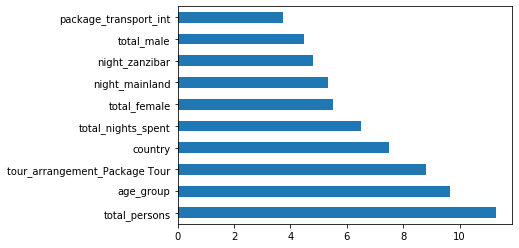

In [12]:
#Feature importance plot.

feat_importances = pd.Series(cat.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

> The feature importance plot is very important when deciding which feature interactions to explore. For example, there might be a relationship between totalnumber of visitors and their age groups. Multiplying those two into another column would add more categories and potentially a better score.


> It's not a science though, it's an art. after every trial, I'd upload the file and see if it worked. 


> I finally came up with 4 features that improved my score on the public leaderboard to 509, which was the best. 

> I however knew that the public leaderboard was just 50% of the test data and a better generalized model would potentially perform better.

# Best solution

In [57]:


# Feature engineering and exploring feature interactions
data["total_persons"] = data["total_female"] + data["total_male"]
data['total_persons'] = data['total_persons'].astype('int')

data['mgf2'] = data['payment_mode'] + data['purpose']
data['mgf3'] = data['country'] + data['tour_arrangement']
data['mgf4'] = data['total_persons'] * data['age_group']
data["total_nights_spent"] = data["night_mainland"] + data["night_zanzibar"]
data['mf1'] = data['total_nights_spent']*data['total_persons']

# categorical features encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
data['age_group'] = le.fit_transform(data['age_group'])
data['package_transport_int'] = le.fit_transform(data['package_transport_int'])
data['package_accomodation'] = le.fit_transform(data['package_accomodation'])
data['package_food'] = le.fit_transform(data['package_food'])
data['package_transport_tz'] = le.fit_transform(data['package_transport_tz'])
data['package_sightseeing'] = le.fit_transform(data['package_sightseeing'])
data['package_guided_tour'] = le.fit_transform(data['package_guided_tour'])
data['package_insurance'] = le.fit_transform(data['package_insurance'])
data['first_trip_tz'] = le.fit_transform(data['first_trip_tz'])
data['country'] = le.fit_transform(data['country'])
columns_to_transform = ['tour_arrangement','travel_with','purpose','main_activity','info_source','most_impressing','payment_mode', 'mgf2','mgf3', 'mgf4']
data = pd.get_dummies( data,columns = columns_to_transform,drop_first=True)


## convert float dtypes to int
data["total_female"] = data['total_female'].astype('int')
data["total_male"] = data['total_male'].astype('int')
data["night_mainland"] = data['night_mainland'].astype('int')
data["night_zanzibar"] = data['night_zanzibar'].astype('int')



## separate data into train and test
train=data[data.total_cost.notnull()].reset_index(drop=True)
test_1=data[data.total_cost.isna()].reset_index(drop=True)

X = train.drop(columns=['ID', 'total_cost'])
y = train['total_cost']
test=test_1.drop(columns=['ID', 'total_cost'])

## Stacking and Blending

> The basic architecture was two layers, each with models with varying hyperparameters, then stacked to create a set of predictions on the test data using catboost as the meta learner, then averging those two predictions together and then with another set of predictions by a lone Catboost model.

> setting the evaluation metric / loss function of each model to MAE was also very important.

> This technique achieved a public LB score of 506.

In [58]:
# Stacking with linear models, SVM, KNN and Decision trees and many variations of them. 
# The variations are different values of key parameters of each model. 
# While I did not have the time to tune parameters of each model, except the meta learner Catboost, educated guesses on 
# the parameters were made to have as much variability as possible.

estimators_1 = [
    ('XGBM', XGBRegressor(random_state=2020, learning_rate=0.05, eval_metric='mae', n_jobs=-1)),
    ('LR', LinearRegression()),
    ('LGBM', LGBMRegressor(learning_rate=0.2, random_state=2020, objective='mae')),
    ('SVM', SVR(degree=2)),
    ('Lasso', Lasso(random_state=2020)),
    ('KNN', KNeighborsRegressor(n_neighbors=4, n_jobs=-1)),
    ('CatBoost', CatBoostRegressor(logging_level='Silent', random_state=2020, loss_function='MAE'))
]

predictions_1 = StackingRegressor(n_jobs=-1, cv=5, estimators=estimators_1, final_estimator=CatBoostRegressor(logging_level='Silent', depth=6, bagging_temperature=5, loss_function='MAE', random_state=2020)).fit(X, y).predict(test)

estimators_2 = [
    ('XGB', XGBRegressor(learning_rate=0.2, random_state=2020, eval_metric='mae')),
    ('LR', LinearRegression()),
    ('RF', RandomForestRegressor(random_state=2020, criterion='mae')),
    ('LGBM', LGBMRegressor(learning_rate=0.05, random_state=2020, objective='mae')),
    ('SVM', SVR(degree=5)),
    ('KNN', KNeighborsRegressor(n_neighbors=6, n_jobs=-1)),
    ('CatBoost', CatBoostRegressor(logging_level='Silent', random_state=2020, loss_function='MAE'))
]

predictions_2 = StackingRegressor(n_jobs=-1, cv=4, estimators=estimators_2, final_estimator=CatBoostRegressor(logging_level='Silent', depth=6, bagging_temperature=5, loss_function='MAE', random_state=2020)).fit(X, y).predict(test)

predictions_cat_1 = CatBoostRegressor(logging_level='Silent', depth=6, loss_function='MAE', bagging_temperature=5, random_state=2020).fit(X, y).predict(test)


# Further averaging to generalise well
# While the ratios are greater than one, it still works a treat. This is definitely one of the parameters to tune to achieve great results.
stack = [x*0.3 + y*0.7 for x, y in zip(predictions_1, predictions_2)]
stack_2 = [x*0.4 + y*0.65 for x, y in zip(stack, predictions_cat_1)]

# submission file
submission_df = pd.DataFrame({'ID': test_1.ID, 'total_cost': stack_2})
submission_df.to_csv('final.csv',index=False)